### Changing to the main directory

In [1]:
%cd ..

/home/isham/Desktop/machine-learning-projects/misc_ai_projects/elec-device-feedback-classification


/home/isham/anaconda3/envs/image_classification/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Importing Necessary Libraries

In [2]:
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

from utilities import MODEL_ID, DATASET_ID, OUTPUT_DATASET_PATH

### Loading the Dataset

In [3]:
dataset = load_dataset(DATASET_ID)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11552
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1352
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1352
    })
})

In [5]:
# Assuming your current dataset is stored in 'dataset'
# First, let's split the training set into train and validation
train_test = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Now split the test portion into validation and test
validation_test = train_test['test'].train_test_split(test_size=0.5, seed=42)

# Create the final DatasetDict with all three splits
dataset = DatasetDict({
    'train': train_test['train'],
    'validation': validation_test['train'],
    'test': validation_test['test']
})

In [6]:
print("Train size:", len(dataset['train']))
print("Validation size:", len(dataset['validation']))
print("Test size:", len(dataset['test']))

Train size: 9241
Validation size: 1155
Test size: 1156


In [7]:
df_train = dataset['train'].to_pandas()
df_validation = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()


In [8]:
df_train['count'] = df_train['text'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

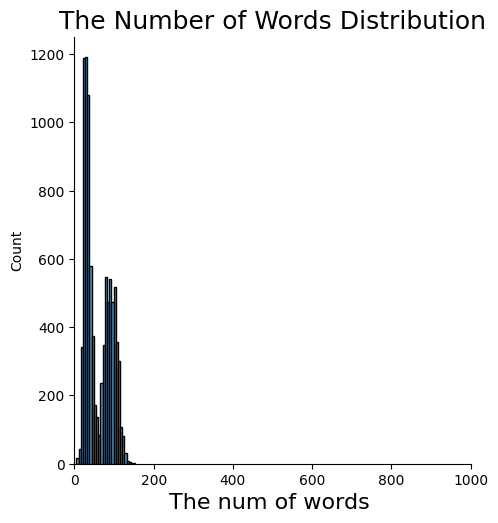

In [9]:
plt.figure(figsize= (8, 8))

sns.displot(df_train['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

The histogram shows the distribution of word counts in your electrical feedback dataset. The key observations are:

1. Most feedback texts are relatively short:
    - Highest frequency is around 20-40 words
    - Sharp peak at the lower end
    - Long tail extending to about 200 words


2. Distribution characteristics:
    - Right-skewed (positive skew)
    - Maximum count appears to be around 1500 instances
    - The majority of texts contain fewer than 100 words
    - Very few texts are longer than 200 words

This distribution is typical for customer feedback data, where most people tend to provide concise feedback. The length distribution should be fine for model training, especially for transformer-based models like BERT and ModernBERT which have a standard token limit (usually 512 tokens and 8092 tokens respectively).

### Tokenizing the whole dataset

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [11]:
text = "I love Machine Learning!. Tokenization is awesome"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [50281, 42, 2389, 21585, 20727, 47346, 35097, 1320, 310, 13103, 50282], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'I', 'Ġlove', 'ĠMachine', 'ĠLearning', '!.', 'ĠToken', 'ization', 'Ġis', 'Ġawesome', '[SEP]']


In [13]:
tokenizer.vocab_size, tokenizer.model_max_length

(50280, 1000000000000000019884624838656)

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [15]:
dataset["train"][1]

{'text': "I recently purchased a smart meter for my home, but I'm having trouble setting up the energy monitoring feature. The instructions are unclear and the customer support team hasn't been very responsive. However, I must say that the device itself is well-built and looks sleek in my basement.",
 'label': 0}

In [16]:
print(tokenize(dataset["train"][1]))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [50281, 42, 4102, 9716, 247, 7060, 21623, 323, 619, 1728, 13, 533, 309, 1353, 1907, 7596, 4758, 598, 253, 2341, 8667, 4735, 15, 380, 7997, 403, 12744, 285, 253, 7731, 1329, 2285, 11210, 626, 644, 1077, 20876, 15, 1723, 13, 309, 1364, 1333, 326, 253, 2813, 3139, 310, 973, 14, 20989, 285, 4453, 47115, 275, 619, 21135, 15, 50282], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded

Map:   0%|          | 0/7208 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/902 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7208
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 901
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 902
    })
})

### Saving the Dataset

In [18]:
dataset_encoded.save_to_disk(OUTPUT_DATASET_PATH)

Saving the dataset (0/1 shards):   0%|          | 0/7208 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/902 [00:00<?, ? examples/s]